In [1]:
!pip install tensorflow scikit-learn

In [20]:



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.seasonal import seasonal_decompose


In [29]:
# Đọc dữ liệu
df = pd.read_csv('wti_prices.csv')
df

,date,open,high,low,close,volume,average
0,2024-04-04,75.90,76.71,75.44,76.46,4467.0,76.149
1,2024-04-05,76.54,76.91,76.23,76.41,3429.0,76.552
2,2024-04-08,76.57,76.74,75.54,76.18,2276.0,76.070
3,2024-04-09,76.42,76.52,75.48,75.63,1811.0,75.900
4,2024-04-10,76.01,76.48,75.45,76.27,3500.0,76.077
...,...,...,...,...,...,...,...
2076,2017-03-30,54.95,54.95,54.95,54.95,0.0,54.950
2077,2017-03-31,55.44,55.44,55.44,55.44,0.0,55.440
2078,2017-04-03,55.83,55.83,55.83,55.83,0.0,55.830
2079,2017-04-04,56.18,56.18,56.18,56.18,0.0,56.180


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2081 entries, 0 to 2080
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     2081 non-null   object 
 1   open     2081 non-null   float64
 2   high     2081 non-null   float64
 3   low      2081 non-null   float64
 4   close    2081 non-null   float64
 5   volume   2081 non-null   float64
 6   average  2081 non-null   float64
dtypes: float64(6), object(1)
memory usage: 113.9+ KB


In [31]:


#chuyển cột date sang datetime & sort đúng thứ tự thời gian
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(df.head())
print(df.tail())

print(df[['date','close']].tail())


        date   open   high    low  close  volume  average
0 2016-11-23  58.66  58.66  58.66  58.66     0.0    58.66
1 2016-11-25  57.32  57.32  57.32  57.32     0.0    57.32
2 2016-11-28  57.85  57.85  57.85  57.85     0.0    57.85
3 2016-11-29  56.51  56.51  56.51  56.51     0.0    56.51
4 2016-11-30  58.29  58.29  58.29  58.29     0.0    58.29
           date   open   high    low  close   volume  average
2076 2025-03-28  69.35  69.36  68.42  68.60  19924.0   68.864
2077 2025-03-31  69.33  71.24  69.06  70.87  35933.0   70.542
2078 2025-04-01  71.15  71.52  70.58  70.69  27070.0   70.946
2079 2025-04-02  70.40  71.76  70.11  70.22  28972.0   70.913
2080 2025-04-03  66.25  66.75  65.60  66.09  24973.0   66.108
           date  close
2076 2025-03-28  68.60
2077 2025-03-31  70.87
2078 2025-04-01  70.69
2079 2025-04-02  70.22
2080 2025-04-03  66.09


In [32]:
#Kiểm tra trùng lặp
df.duplicated().sum()

np.int64(3)

In [33]:
#xử lý trùng lặp
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

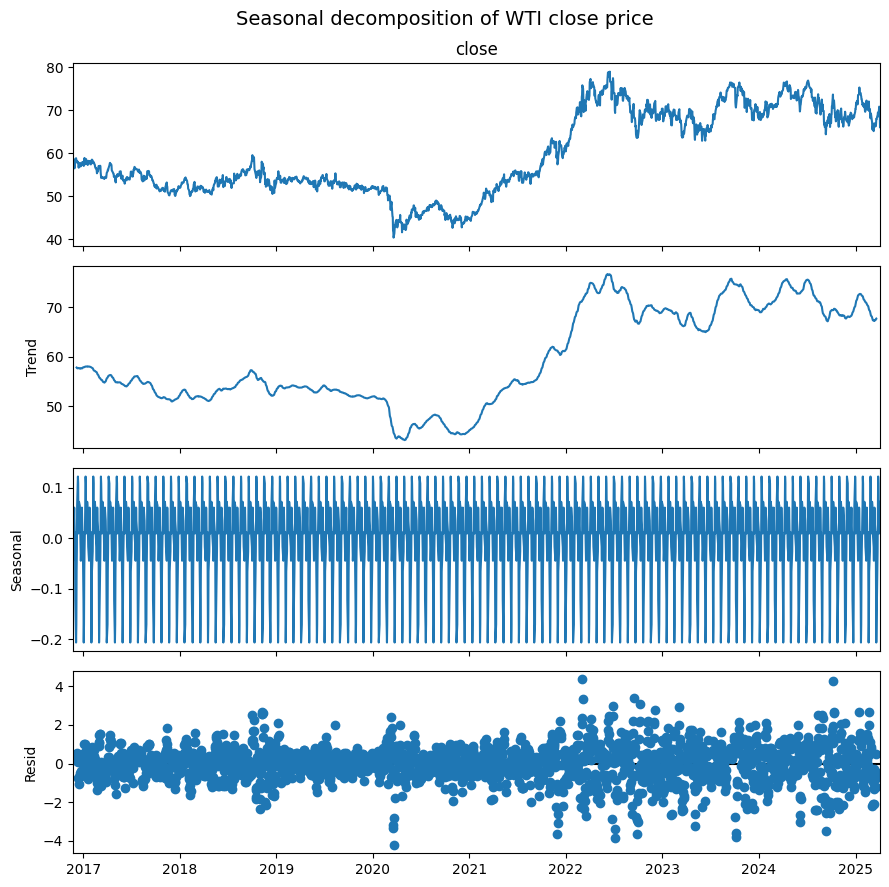

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Nếu date chưa là index thì set lại (nếu đã set rồi thì bỏ dòng này)
ts = df.set_index('date')['close']

# Ép tần suất về ngày làm việc & fill cho decomposition mượt hơn
ts = ts.asfreq('B').ffill()

# Chọn chu kỳ mùa vụ:
#   21 ≈ 1 tháng giao dịch, 252 ≈ 1 năm giao dịch
period = 21   # hoặc 252, tuỳ bạn muốn xem seasonality nào

# Decompose chuỗi: close = trend + seasonal + resid
result = seasonal_decompose(ts, model='additive', period=period)

# Vẽ biểu đồ gồm 4 phần: gốc, trend, seasonal, residual
fig = result.plot()
fig.set_size_inches(9, 9)
fig.suptitle('Seasonal decomposition of WTI close price', fontsize=14)
plt.tight_layout()
plt.show()


In [35]:
# Các cột cơ bản
feature_cols = ['open', 'high', 'low', 'close',]

# Nếu file có thêm cột 'average' thì dùng luôn
if 'average' in df.columns:
    feature_cols.append('average')

print("Feature dùng:", feature_cols)

# Ma trận X và vector y
X_raw = df[feature_cols].values             # (N, n_features)
y_raw = df['close'].values.reshape(-1, 1)   # (N, 1)


Feature dùng: ['open', 'high', 'low', 'close', 'average']


In [36]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)


In [37]:
window_size = 60   # 30 / 60 / 90

def create_multifeature_dataset(X, y, window_size):
    X_out, y_out = [], []
    for i in range(len(X) - window_size):
        # lấy đoạn [i, i+window_size) làm input
        X_out.append(X[i:i+window_size, :])   # (window_size, n_features)
        # giá close tại thời điểm i+window_size là target
        y_out.append(y[i+window_size, 0])
    return np.array(X_out), np.array(y_out)

X_seq, y = create_multifeature_dataset(X_scaled, y_scaled, window_size)
print("X_seq shape:", X_seq.shape)   # (n_samples, T, F)
print("y shape:", y.shape)           # (n_samples,)


X_seq shape: (2018, 60, 5)
y shape: (2018,)


In [38]:
n_samples, T, F = X_seq.shape
X = X_seq.reshape(n_samples, T * F)  # (n_samples, T*F)
input_dim = X.shape[1]
print("X shape sau flatten:", X.shape)

# Mảng ngày ứng với từng mẫu y (bắt đầu từ dòng window_size)
dates_all = df['date'].iloc[window_size:].reset_index(drop=True)
print("len dates_all:", len(dates_all), "len y:", len(y))


X shape sau flatten: (2018, 300)
len dates_all: 2018 len y: 2018


In [39]:
n = len(X)
train_end = int(n * 0.7)
val_end   = int(n * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

dates_train = dates_all[:train_end]
dates_val   = dates_all[train_end:val_end]
dates_test  = dates_all[val_end:]

print("Train:", X_train.shape, len(dates_train))
print("Val:  ", X_val.shape,   len(dates_val))
print("Test: ", X_test.shape,  len(dates_test))


Train: (1412, 300) 1412
Val:   (404, 300) 404
Test:  (202, 300) 202


In [40]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # LR nhỏ để học mượt hơn
    loss='mse'
)

model.summary()

es = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,873 (687.00 KB)

 Trainable params: 175,873 (687.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0118 - val_loss: 0.0029
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7527e-04 - val_loss: 0.0017
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8621e-04 - val_loss: 0.0013
Epoch 5/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5902e-04 - val_loss: 0.0044
Epoch 6/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9757e-04 - val_loss: 0.0018
Epoch 7/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3354e-04 - val_loss: 0.0010
Epoch 8/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9344e-04 - val_loss: 0.0028
Epoch 9/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0900e-04 - val_loss: 0.0012
Epoch 11/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2095e-04 - val_loss: 0.0019
Epoch 12/500
45/45 ━━━━━━━━━━━

In [42]:
# Dự đoán trên test
y_pred_scaled = model.predict(X_test)

# Đưa về giá thật
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

# Toàn bộ y (train+val+test) về giá thật để vẽ lịch sử
y_all_inv = scaler_y.inverse_transform(y.reshape(-1, 1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [43]:
mae = np.mean(np.abs(y_test_inv - y_pred_inv))
rmse = np.sqrt(np.mean((y_test_inv - y_pred_inv)**2))
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")


MAE  = 0.8911
RMSE = 1.1378


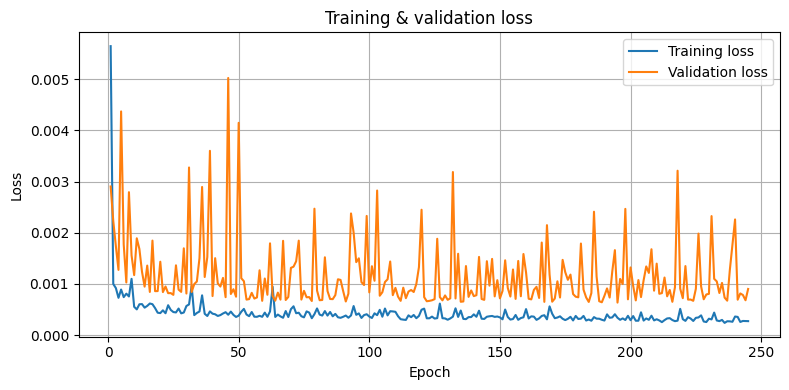

In [44]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & validation loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


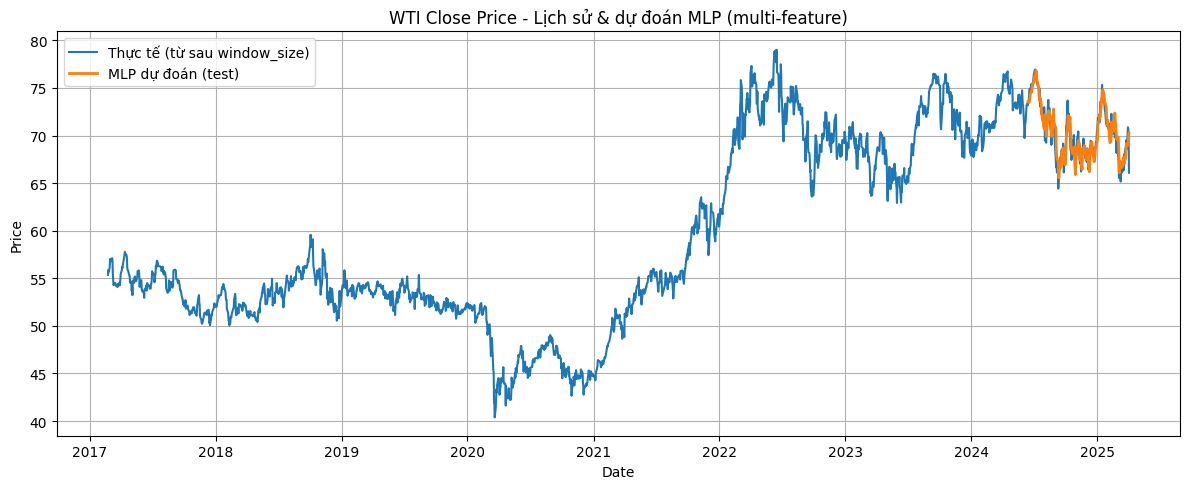

In [45]:
# Mảng dự đoán full (NaN ở train+val, có giá trị ở test)
pred_all = np.full_like(y_all_inv, np.nan)
pred_all[val_end:] = y_pred_inv

plt.figure(figsize=(12, 5))
plt.plot(dates_all, y_all_inv, label='Thực tế (từ sau window_size)')
plt.plot(dates_all, pred_all, label='MLP dự đoán (test)', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('WTI Close Price - Lịch sử & dự đoán MLP (multi-feature)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


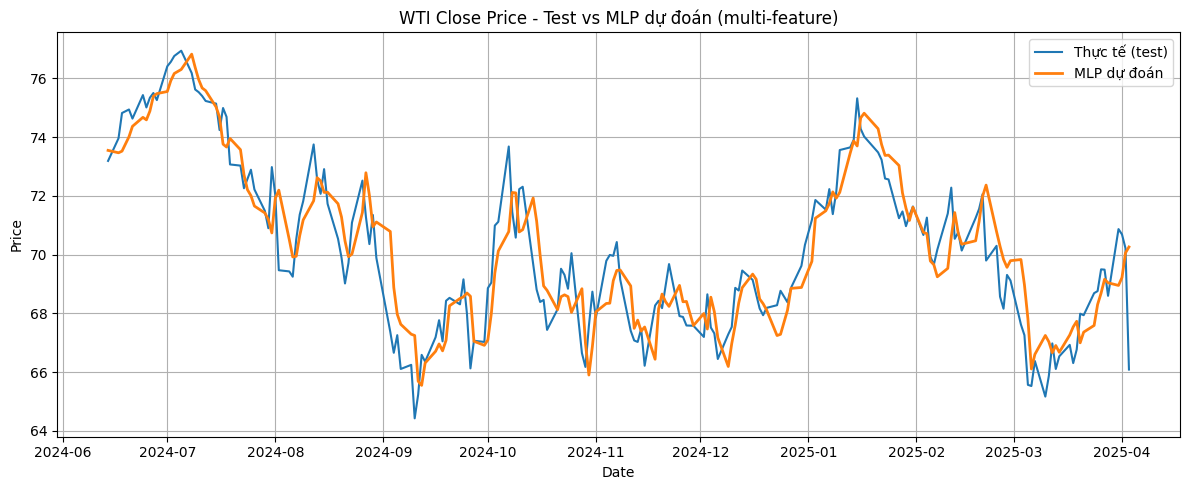

In [46]:
plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test_inv,  label='Thực tế (test)')
plt.plot(dates_test, y_pred_inv, label='MLP dự đoán', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('WTI Close Price - Test vs MLP dự đoán (multi-feature)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
